In [2]:
%matplotlib inline
%pylab inline
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand


Populating the interactive namespace from numpy and matplotlib


In [3]:
def load_data(path, shuffle = True, normalize = True):
    gc.collect()
    labels = list(pandas.read_hdf(path, '/df').columns.values)#.get('accrued_depr_pct')
    data = pandas.read_hdf(path, '/df')
    
    np_data = np.array(data).astype(float)
    del(data)
    data=None
    #np_data = np_data / np_data.max(axis=0)
    def scale_linear_by_column(rawpoints, high=1.0, low=0.0):
        mins = np.min(rawpoints, axis=0)
        maxs = np.max(rawpoints, axis=0)
        rng = maxs - mins
        return high - (((high - low) * (maxs - rawpoints)) / rng)
    if normalize:
        np_data = scale_linear_by_column(np_data)
    
    if shuffle:
        np.random.shuffle(np_data)
        print "shufflin:!!!"
    np.nan_to_num(np_data)
    
    np_data[np.isnan(np_data)] = 0.0
    
    return np_data, labels

def load_nonumerical_data(path):
    gc.collect()
    labels = list(pandas.read_hdf(path, '/df').columns.values)#.get('accrued_depr_pct')
    data = pandas.read_hdf(path, '/df')
    return data, labels

def get_nparray_of_nonnumerical_data_sorted_by_first_column(table):
    #sometimes hcads are read in as strings
    numerical_data = np.array(table[0])
    for i in range(len(numerical_data)):
        numerical_data[i,0] = int(numerical_data[i,0])
    numerical_data = sorted(numerical_data, key=lambda x:x[0])
    numerical_data = np.array(numerical_data)
    return numerical_data  

def print_columns(path):
    labels = list(pandas.read_hdf(path, '/df').columns.values)#.get('accrued_depr_pct')
    print labels


In [4]:
def visualize(muh_data, buckets = 100, show=False, size=40, path=None, 
              bandwidth=2, display_mode='kde', color = None, glyph = '+'):
    vis_x = muh_data[:, 0]
    vis_y = muh_data[:, 1]


    #histogram definition
    if size == None:
        xyrange = [[min(vis_x),max(vis_x)],[min(vis_y),max(vis_y)]]
    else:
        xyrange = [[-size,size],[-size,size]] # data range
    bins = [buckets,buckets] # number of bins
    
    if(show):
        #
        #sns.set(color_codes=True)
        if(display_mode=='kde'):
            fig = plt.figure(frameon=False)
            fig.set_size_inches(30,30)
            sns.kdeplot(vis_x, vis_y, shade=True,  n_levels=20, bw=bandwidth)
        elif display_mode == 'hex':
            sns.jointplot(x=vis_x, y=vis_y, kind="hex", color="k", size = 30)
        elif display_mode == 'hist':
            hh, locx, locy = scipy.histogram2d(vis_x, vis_y, range=xyrange, bins=bins)
            fig = plt.figure(frameon=False)
            fig.set_size_inches(30,30)
            plt.imshow(np.flipud(hh.T),cmap='jet', extent=np.array(xyrange).flatten(), interpolation='none', shape = (1000,1000))
            plt.colorbar()
        elif display_mode == 'colored':
            #plt.gray()
            fig = plt.figure(frameon=False)
            fig.set_size_inches(20,20)
            plt.scatter(vis_x, vis_y, c=color,  marker=glyph, facecolor='b', cmap='jet')

            
            #fig.patch.set_facecolor('blue')

            #plt.set_axis_bgcolor((0, .5, .5))
            #plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', shape = (1000,1000))
            plt.colorbar()
        plt.show()
    else:
        assert(path != None)
        save_path = folder+"".join(path.split('/')[-2:])
        save_path = save_path+"_buckets:"+str(buckets)
        save_path = save_path  +".png"
        plt.savefig(save_path)
    #plt.clf()

def save(muh_data, folder, tag=""):
    save_path = folder+"np_array_"+tag
    print "saving to",save_path
    np.save(save_path,muh_data)

## tSNE embedding

In [20]:
def process_full():
    paths = [#"/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df.hd",
#              "/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_100.hd",
             "/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd",
             #"/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_400.hd",
             # "/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd",
              #"/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_100.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_400.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_1000.hd",
#               "/home/isaac/Dropbox/data_for_brian/terrain_features/dtmgrid/terrain_100.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dtmgrid/terrain_200.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dtmgrid/terrain_400.hd",
#              "/home/isaac/Dropbox/data_for_brian/terrain_features/dtmgrid/terrain_1000.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist16x16.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist36x36.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist36x36.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad400_hist8x8.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad400_hist16x16.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad400_hist36x36.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad1000_hist8x8.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad1000_hist16x16.mat.hd",
#              "/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad1000_hist36x36.mat.hd"
            ]
    meta_path = "/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd"
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    wind_features = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd")
    print wind_features
    wind_features = get_nparray_of_nonnumerical_data_sorted_by_first_column(wind_features)

    #print "WIND FEATURES:"
    #print wind_features
    terrain_features = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd")
    print terrain_features
    terrain_features_sorted = get_nparray_of_nonnumerical_data_sorted_by_first_column(terrain_features)

    folder = "./gitignored/terrain_only/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    print "started at "+strftime("%Y-%m-%d %H:%M:%S", gmtime())
    vis_data = None
    for path in paths:
        np_data, column_labels = load_data(path, shuffle = False, normalize=True)
        # sort the hcad data by the hcad column
        np_data = np.array(sorted(np_data, key=lambda x:x[0]))

        #print column_labels
        for n in [None]:
            sliced_np_data = np_data[:n]
            # eliminate the HCAD number column
            sliced_np_data_withou_hcad  = sliced_np_data[:,[0,5,6,14,22,23,26,29,30]] 
            print (len(sliced_np_data_withou_hcad))
            # add lat and lon
            # sliced_np_data_withou_hcad = np.column_stack((sliced_np_data_withou_hcad, lat))
            # sliced_np_data_withou_hcad = np.column_stack((sliced_np_data_withou_hcad, lon))
#             print terrain_features

            #ONLY USE TERRAIN DATA
            sliced_np_data_withou_hcad = col =  terrain_features_sorted[:,terrain_features[1].index("200_3")]
            for item in ["200_1", "slp200_3", "sca200_3", "sca200_1", "fel200_3", "ang200_3", "slp200_1", "fel200_1", "ang200_1"]:
                print type(item)
                col =  terrain_features_sorted[:,terrain_features[1].index(item)]
                col = col-np.min(col)
                col =  col/np.max(col)
                print col
                sliced_np_data_withou_hcad = np.column_stack((sliced_np_data_withou_hcad, col))
#             for item in ["hist34", "hist20", "hist17", "hist33", "hist35", "hist58", "hist41", "hist16", "hist51", "hist50"]:
#                 col =  wind_features[0][item]
#                 col = col-np.min(col)
#                 col =  col/np.max(col)
#                 sliced_np_data_withou_hcad = np.column_stack((sliced_np_data_withou_hcad,col))
            # run tsne
            print sliced_np_data
            vis_data = bh_sne(sliced_np_data_withou_hcad, perplexity=1)
            
            # save results
            dataset_name = path.split('/')[-1].split('.')[0]
#             save(np.append(vis_data, sliced_np_data,1), folder, tag = "n="+str(n)+"_of_"+dataset_name+"_perp_1")
            save(vis_data, folder, tag = "n="+str(n)+"_of_"+dataset_name+"_perp_1")
            
            for i in range(1, len(np_data[0,:])):
                print "\n"+"="*20
                print "dataset:", dataset_name
                print "sample size:",len(vis_data)
                print "\ncolumn:",column_labels[i]+":"
                colors = np_data[:n,i]
                print "log plot:"
                visualize(vis_data, show=True, display_mode = 'colored', color = np.log(colors+.1))
                print "linear plot:"
                visualize(vis_data, show=True, display_mode = 'colored', color = colors)

            del(vis_data)
            vis_data=None
            print "done with "+path+" at "+strftime("%Y-%m-%d %H:%M:%S", gmtime())
        del(np_data)
        np_data=None
        gc.collect()
            
process_full()

Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd in read-only mode
(           hcad        lat        lon  intp_spd0   intp_dir0  intp_spd1  \
0   42070200019  29.599451 -95.413479   7.934372  202.447526   8.526513   
1   42070200026  29.599809 -95.414148   7.931357  202.447735   8.522368   
2   42070200028  29.599973 -95.413483   7.932776  202.449884   8.524565   
3   42070200030  29.599378 -95.414116   7.932761  202.445846   8.524103   
4   42070200029  29.599910 -95.413774   7.932128  202.448983   8.523572   
5   60890780002  29.774625 -95.698504   6.712430  202.636043   6.853413   
6   60890780005  29.774730 -95.699415   6.710164  202.635060   6.850092 

KeyboardInterrupt: 

In [6]:
def visualize_all_data():
    mypath = "/home/isaac/Desktop/devika/gitignored/autorun17_200m_30top10features/"
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

    for file in onlyfiles:
        if file == "np_array_n=None_of_hcad_df_200_perp_1.npy":
            load_path = mypath+str(file)#np_array_8000_terrain_100.npy"
            y_data = (np.array(load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")[0]["y100_mean"]))
            tsne_data = np.load(load_path)
            print "total number of tsne points loaded", len(tsne_data)

            damaged_indices = filter(lambda i: y_data[i] != 0.0, list(range(len(y_data))))
            damaged_embedding_points= np.array([tsne_data[x] for x in damaged_indices])
            undamaged_indices = filter(lambda i: y_data[i] == 0.0, list(range(len(y_data))))
            undamaged_embedding_points= np.array([tsne_data[x] for x in undamaged_indices])
                
            print "number of damaged points", len(damaged_embedding_points)

            
            
            print "\n\n---->n="+file.split('_')[2] + " " + '_'.join(file.split('_')[3:])
            print "kde bandwidth 1"
            size = max([max(tsne_data[:,0]),max(tsne_data[:,1]),abs(min(tsne_data[:,0])),abs(min(tsne_data[:,1]))])
            print "damaged"
            visualize(damaged_embedding_points, show=True, size=size, bandwidth=.1, display_mode='hist', buckets= 150)
            print "undamaged"
            visualize(undamaged_embedding_points, show=True, size=size, bandwidth=.1, display_mode='hist', buckets= 199)

            #print "kde bandwidth 2"
            #visualize(loaded_data, show=True, size=size, bandwidth=2)
            print "hex histogram"
            visualize(damaged_embedding_points, show=True, size=size, bandwidth=1, display_mode='hex')
            visualize(undamaged_embedding_points, show=True, size=size, bandwidth=1, display_mode='hex')
            #print "histogram"
            #visualize(loaded_data, show=True, size=size, bandwidth=1, display_mode='hist')
# visualize_all_data()

In [7]:
def run_tests():
    path = "/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df.hd"
    np_data, labels = load_data(path)
    for i in range(len(np_data[0])):
        col = np_data[:,i]
        assert len(np_data[0]) == len(labels)
        assert len(col) == 870476
        assert np.max(col) == 1.0
        assert np.min(col) == 0.0
    print "tests pass"
#run_tests()

## Plots of data mapped to space

In [8]:
print_columns("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
print_columns("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df.hd")

Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
['hcad', 'lat', 'lon', 'pointx', 'pointy', 'keymap', 'img0', 'img1']
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df.hd in read-only mode
['accrued_depr_pct', 'active_area', 'assessed_val', 'base_area', 'bld_ar', 'bld_val', 'bldg_adj', 'cama_replacement_cost', 'dpr_val', 'effective_area', 'gross_area', 'heated_area', 'improved_sqft', 'land_ar', 'land_val', 'new_construction_val', 'perimeter', 'prior_bld_val', 'prior_land_val', 'prior_tot_appr_val', 'prior_tot_mkt_val', 'prior_x_features_val', 'quality', 'rcnld', 'size_index', 'tot_appr_val', 'tot_mkt_val', 'tot_rcn_val', 'x_features_val', 'year_built', 'year_remodeled', 'yr_impr']


In [18]:
from random import sample
def print_damage_columns():
    y_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
    print y_data
#print_meta_columns()

def plot_hcad_data_on_map():
    hcad_data, labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd",
                                  shuffle = False, normalize = False)

    hcad_data = np.array(sorted(hcad_data, key=lambda x:x[0]))


    sample_size = len(hcad_data)
    sample_indices = sample(xrange(len(hcad_data)), sample_size)
    #meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    #meta_data_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(meta_data)
    #xy_points = np.array(zip(meta_data_data[:,1],meta_data_data[:,2]))
    terrain_features = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd")
    terrain_data = np.array(terrain_features[0])
    #print terrain_data
#     terrain_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(meta_data)
    xy_points = np.array(zip(terrain_data[:,1],terrain_data[:,2]))
    

    #sample_size = len(hcad_data)
    #sample_indices = sample(xrange(len(hcad_data)), sample_size)
    ##xy_points = np.array(zip(terrain_features[0]['lon'],terrain_features[0]['lat']))
    for i in range(len(labels)):
        print labels[i]
        hcad_column = hcad_data[:,i]

        print hcad_column
        plt.hist(np.clip(hcad_column,0,300000), 100, normed=1, facecolor='green', alpha=0.75)
        plt.show()

#         visualize(xy_points, 
#             size=None,show = True, display_mode='colored', 
#             color = hcad_column)
#         xy_points = np.array(zip(terrain_features[0]['lon'],terrain_features[0]['lat']))
        visualize(xy_points, 
            size=None,show = True, display_mode='colored', 
            color = hcad_column)     
        visualize(xy_points, 
            size=None,show = True, display_mode='colored', 
            color = np.log(hcad_column))
        color_sample = None
        
        
        #for i in range(1000):
        

        
def plot_other_data_on_map(path):
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
#     print meta_data
    meta_data_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(meta_data)
#     print meta_data_data
    terrain_features = load_nonumerical_data(path)
    terrain_features_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(terrain_features)
    print terrain_features_data
    print meta_data_data
    #sample_size = len(hcad_data)
    #sample_indices = sample(xrange(len(hcad_data)), sample_size)
    xy_points = np.array(zip(meta_data_data[:,1],meta_data_data[:,2]))
#     xy_points = np.array(zip(terrain_features_data[:,1],terrain_features_data[:,2]))

#     xy_points = np.array(zip(terrain_features[0]['lon'],terrain_features[0]['lat']))
    for i, item in enumerate(terrain_features[0]):
        col =  terrain_features_data[:,i]
        label = str(item)
        print "\n\n"
        print label
        print np.array(col)
        print "linear plot"
        visualize(xy_points, 
            size=None,show = True, display_mode='colored', 
            color = col)
        print "log plot"
        visualize(xy_points, 
            size=None,show = True, display_mode='colored', 
            color = np.log(col))
        color_sample = None
        

def show_ratio_plot():  #This needs to be done properly.  It's broken now.
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    print meta_data
    meta_data_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(meta_data)
#     print meta_data_data
    terrain_features = load_nonumerical_data(path)
    terrain_features_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(terrain_features)
    buckets = defaultdict(list)
    x_min = np.min(meta_data_data[:,1])
    x_max = np.max(meta_data_data[:,1])
    y_min = np.min(meta_data_data[:,2])
    y_max = np.max(meta_data_data[:,2])
    print x_min, x_max
    resolution = 500
    for column_index, column_name in enumerate(terrain_features[0]):
        for i, location in enumerate(terrain_features[:,column_index]):
            x,y = tsne_embedding[i][0], tsne_embedding[i][column_index]
            x += -x_min
            x /= x_max - x_min
            y += -y_min
            y /= y_max - y_min
            x = int(x*resolution)
            y = int(y*resolution)
            buckets[(x,y)].append(y_data[i, 1])
    locations_to_damaged_ratios = defaultdict(float)
    for key in buckets:
        locations_to_damaged_ratios[key] = float(sum(buckets[key]))/float(len(buckets[key]))
#     print locations_to_damaged_ratios
    x_y_ratio = numpy.zeros((resolution+1,resolution+1))
    for key in locations_to_damaged_ratios:
        #print key
        x_y_ratio[key[0],key[1]] = locations_to_damaged_ratios[key]
    #print x_y_ratio
#     x,y,temp = np.loadtxt('data.txt').T #Transposed for easier unpacking
#     nrows, ncols = 50, 50
#     grid = temp.reshape((nrows, ncols))
    plt.hist(locations_to_damaged_ratios.values())
    plt.show()

    fig = plt.figure(frameon=False)
    fig.set_size_inches(30,30)
    plt.imshow(np.log(x_y_ratio), 
               interpolation='nearest', cmap=cm.gist_rainbow)
    plt.show() 
# plot_hcad_data_on_map()
# plot_other_data_on_map("/home/isaac/Dropbox/data_for_brian/y_df.hd")
# plot_other_data_on_map("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd")
show_ratio_plot()

Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
(             hcad        lat        lon   pointx    pointy keymap  img0  img1
0    591510110210  29.780199 -95.017899  3231440  13852700   500G     0     0
1    971700000086  29.667601 -95.526299  3071470  13806600   530X     0     0
2    591510110215  29.780199 -95.018501  3231240  13852700   500G     0     0
3   1135540000087  30.062799 -95.196999  3171330  13953600   297W     0     0
4    660460230019  29.821100 -95.414101  3105360  13863500   452Q     0     0
5    971700000088  29.667601 -95.526703  3071340  13806600   530X     0     0
6   1239250020035  29.868500 -95.712799  3010230  13878000   406V     0     0
7   1084010000003  30.053301 -95.205399  3168790  13950000   336D     0     0
8    660460230020  29.821301 -95.414101  3105380  13863600   452Q     0     0
9    901120000007  29.754000 -95.510696  3075480  13838200   490R

NameError: global name 'path' is not defined

## color tSNE plots by damage

In [10]:
def color_tsne_by_damage():
    tSNE_and_data = np.load("/home/isaac/Desktop/devika/gitignored/autorun13_unshuffled/np_array_n=None_of_hcad_df_100_perp_1.npy")
#     print load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
#     y_data = (np.array(load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")[0]["y100_mean"]))
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    meta_data_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(meta_data)
    # index 6 is y200_mean
    print meta_data_data
    y_data = meta_data_data[:,6].astype(float)
    
#     print load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")[0]
    print y_data
    #print tSNE_and_data
    #print np.array([tSNE_and_data[:,1],tSNE_and_data[:,0]])
    t_sne_embedding = np.transpose(np.array([tSNE_and_data[:,0],tSNE_and_data[:,1]]))
#     print t_sne_embedding
    visualize(t_sne_embedding, show = True, size = 15, display_mode = 'colored', color=y_data, glyph='o')
# color_tsne_by_damage()

## Finding distance correlations between tSNE and geographic distance

In [11]:
def find_distance_correlations():
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    xy_points = np.array(zip(meta_data[0].lon,meta_data[0].lat))
    path = "/home/isaac/Desktop/devika/gitignored/autorun13_unshuffled/np_array_n=None_of_hcad_df_perp_1.npy"
    tsne_embedding = np.load(path)
    distances = []
    embed_distances = []
    shuffled_indices = list(range(len(xy_points)))
    shuffle(shuffled_indices)
    samples = [(rand.randint(0,len(xy_points)-1),rand.randint(0, len(xy_points)-1)) for dummy in range(1000000)]
    for sample in samples:
        i,j=sample
        distances.append(math.sqrt( (xy_points[i][0]-xy_points[j][0])**2 + (xy_points[i][1]-xy_points[j][1])**2))
        embed_distances.append(math.sqrt( (tsne_embedding[i][0]-tsne_embedding[j][0])**2 + (tsne_embedding[i][1]-tsne_embedding[j][1])**2))
    #print distances
    #print embed_distances
    print ""
    print pearsonr(distances, embed_distances)
# find_distance_correlations()

                

## correlation between geographic distances and column values

In [13]:
def find_correlations():
    # Does not rely on everything being sorted

    hcad_data, labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd",
                          shuffle = False, normalize = False)
    meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")

    xy_points = np.array(zip(meta_data[0].lon,meta_data[0].lat))

#     shuffled_indices = list(range(len(xy_points)))
#     shuffle(shuffled_indices)
    print len(xy_points), len(hcad_data)
    samples = [(rand.randint(0,len(hcad_data)-1),rand.randint(0, len(hcad_data)-1)) for dummy in range(5000000)]

    for i in range(len (hcad_data[0,:])):
        hcad_column = hcad_data[:,i]
        label = labels[i]
        column_differences = []
        xy_distances = []

        for sample in samples:
            i,j=sample
            column_differences.append(hcad_column[i]-hcad_column[j])
            xy_distances.append(math.sqrt( (xy_points[i][0]-xy_points[j][0])**2 + (xy_points[i][1]-xy_points[j][1])**2))
        #print distances
        #print embed_distances
        print ""
        print label
        print pearsonr(column_differences, xy_distances)[0]
# find_correlations()

                

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
(             hcad        lat        lon   pointx    pointy keymap  img0  img1
0    591510110210  29.780199 -95.017899  3231440  13852700   500G     0     0
1    971700000086  29.667601 -95.526299  3071470  13806600   530X     0     0
2    591510110215  29.780199 -95.018501  3231240  13852700   500G     0     0
3   1135540000087  30.062799 -95.196999  3171330  13953600   297W     0     0
4    660460230019  29.821100 -95.414101  3105360  13863500   452Q     0     0
5    971700000088  29.667601 -95.526703  3071340  13806600   530X     0     0
6   1239250020035  29.868500 -95.712799  3010230  13878000   406V     0     0
7   1084010000003  30.053301 -95.205399

KeyboardInterrupt: 

## Finding other correlations

In [13]:
def find_other_correlations():
#     meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    hcad_data, labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd",
                          shuffle = False, normalize = False)
    path = "/home/isaac/Desktop/devika/gitignored/autorun13_unshuffled/" + "np_array_n=None_of_hcad_df_perp_1.npy"
    tsne_embedding = np.load(path)

#     shuffled_indices = list(range(len(xy_points)))
#     shuffle(shuffled_indices)
    samples = [(rand.randint(0,len(hcad_data)-1),rand.randint(0, len(hcad_data)-1)) for dummy in range(1000000)]

    for i in range(len (hcad_data[0,:])):
        hcad_column = hcad_data[:,i]
        label = labels[i]
        column_differences = []
        embed_distances = []

        for sample in samples:
            i,j=sample
            column_differences.append(hcad_column[i]-hcad_column[j])
            embed_distances.append(math.sqrt( (tsne_embedding[i][0]-tsne_embedding[j][0])**2 + (tsne_embedding[i][1]-tsne_embedding[j][1])**2))
        #print distances
        #print embed_distances
        print ""
        print label
        print pearsonr(column_differences, embed_distances)[0]
# find_other_correlations()

                

## Finding correlations hcad vs damage and others vs damage

In [14]:
def find_hcad_damage_correlations():
#     meta_data = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
    hcad_data, labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd",
                          shuffle = False, normalize = False)
    y_table = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")[0]
    y_data = y_table["y200_mean"]
    samples = [(rand.randint(0,len(hcad_data)-1),rand.randint(0, len(hcad_data)-1)) for dummy in range(1000000)]
    labels_correlations = []
    for i in range(len (hcad_data[0,:])):
        hcad_column = hcad_data[:,i]
        label = labels[i]
        correlation = pearsonr(hcad_column, y_data)[0]
        labels_correlations.append((label, correlation))
    for label, correlation in list(reversed(sorted(labels_correlations, key = lambda x: abs(x[1])))):
        print correlation, label
# find_hcad_damage_correlations()
def find_nonnumerical_damage_correlations(path):
    y_table = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")[0]
    y_data = y_table["y200_mean"]

    terrain_features = load_nonumerical_data(path)

    samples = [(rand.randint(0,len(hcad_data)-1),rand.randint(0, len(hcad_data)-1)) for dummy in range(1000000)]
    labels_correlations = []
    for item in terrain_features[0]:
        col =  terrain_features[0][item]
        label = str(item)
        correlation = pearsonr(col, y_data)[0]
        labels_correlations.append((label, correlation))
    for label, correlation in list(reversed(sorted(labels_correlations, key = lambda x: abs(x[1])))):
        print correlation, label
# find_nonnumerical_damage_correlations("/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd")
# find_nonnumerical_damage_correlations("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd")



## plotting columns on tsne plots

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
['hcad', 'lat', 'lon', 'pointx', 'pointy', 'keymap', 'img0', 'img1']
-11.1466285255 11.6117409801


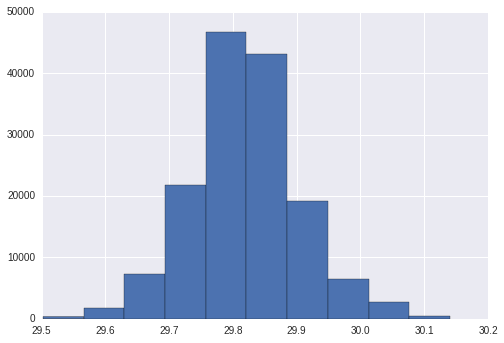

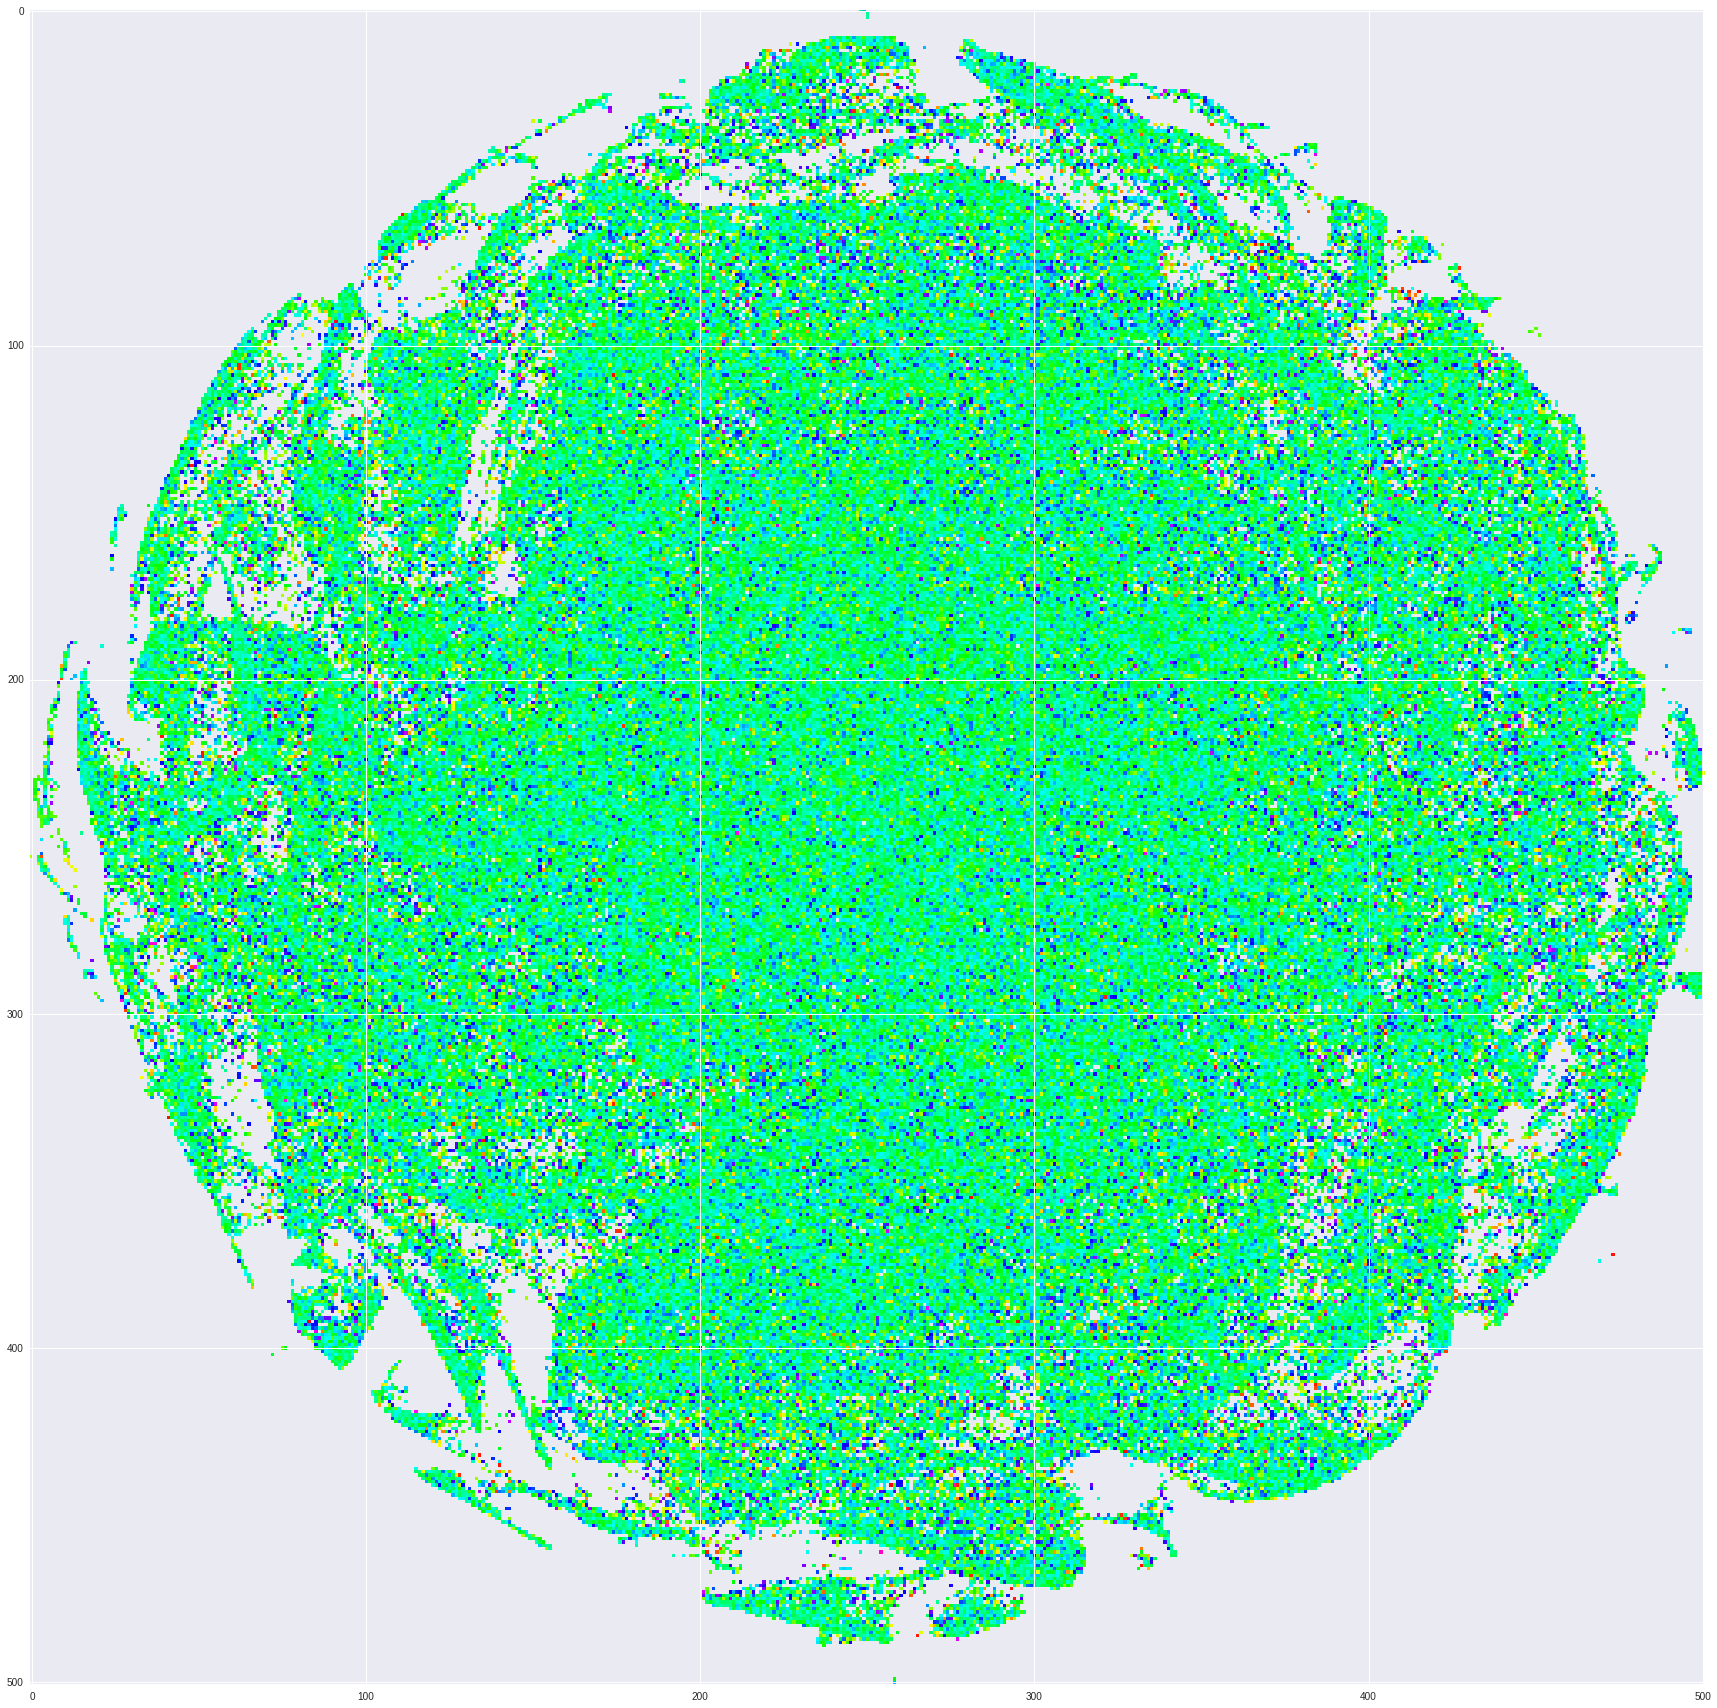

In [41]:
from collections import defaultdict
hcad_data, labels = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd",
                      shuffle = False, normalize = False)

hcad_data = np.array(sorted(hcad_data, key=lambda x:x[0]))

tsne_path = "/home/isaac/Desktop/devika/gitignored/unsorted/autorun12/np_array_n=None_of_hcad_df_100.npy"
tsne_embedding = np.load(tsne_path)
# y_data_nonumerical = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
y_data_nonumerical = load_nonumerical_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")



y_data = get_nparray_of_nonnumerical_data_sorted_by_first_column(y_data_nonumerical)
print y_data_nonumerical[1]
# print "====>", y_data[:,6]
# print y_data_nonumerical

def show_ratio_plot():
    buckets = defaultdict(list)
    x_min = np.min(tsne_embedding[:,0])
    x_max = np.max(tsne_embedding[:,0])
    y_min = np.min(tsne_embedding[:,1])
    y_max = np.max(tsne_embedding[:,1])
    print x_min, x_max
    resolution = 500
    for i, location in enumerate(tsne_embedding):
        x,y = tsne_embedding[i][0], tsne_embedding[i][1]
        x += -x_min
        x /= x_max - x_min
        y += -y_min
        y /= y_max - y_min
        x = int(x*resolution)
        y = int(y*resolution)
        buckets[(x,y)].append(y_data[i, 1])
    locations_to_damaged_ratios = defaultdict(float)
    for key in buckets:
        locations_to_damaged_ratios[key] = float(sum(buckets[key]))/float(len(buckets[key]))
#     print locations_to_damaged_ratios
    x_y_ratio = numpy.zeros((resolution+1,resolution+1))
    for key in locations_to_damaged_ratios:
        #print key
        x_y_ratio[key[0],key[1]] = locations_to_damaged_ratios[key]
    #print x_y_ratio
#     x,y,temp = np.loadtxt('data.txt').T #Transposed for easier unpacking
#     nrows, ncols = 50, 50
#     grid = temp.reshape((nrows, ncols))
    plt.hist(locations_to_damaged_ratios.values())
    plt.show()

    fig = plt.figure(frameon=False)
    fig.set_size_inches(30,30)
    plt.imshow(np.log(x_y_ratio), 
               interpolation='nearest', cmap=cm.gist_rainbow)
    plt.show()
# show_ratio_plot()
    